In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch.optim as optim  # optim 모듈 임포트 추가


import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch import optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

In [ ]:
!pip install numpy
!pip install scikit-learn
!pip install scipy
!pip install nltk
!pip install tqdm
!pip install sentence_transformers
!pip install torch >= 1.4.0
!pip install transformers == 2.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 2.0 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement 1.4.0 (from versions: none)
ERROR: No matching distribution found for 1.4.0
ERROR: Invalid requirement: '=='


In [ ]:
# KoBERT GitHub repository 클론
!git clone https://github.com/SKTBrain/KoBERT.git
# KoSentenceBERT_SKTBERT GitHub repository 클론
!git clone https://github.com/BM-K/KoSentenceBERT_SKTBERT.git

Cloning into 'KoBERT'...
remote: Enumerating objects: 428, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 428 (delta 131), reused 110 (delta 108), pack-reused 273
Receiving objects: 100% (428/428), 221.30 KiB | 2.87 MiB/s, done.
Resolving deltas: 100% (219/219), done.
Cloning into 'KoSentenceBERT_SKTBERT'...
remote: Enumerating objects: 628, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 628 (delta 68), reused 25 (delta 24), pack-reused 531
Receiving objects: 100% (628/628), 46.62 MiB | 23.67 MiB/s, done.
Resolving deltas: 100% (176/176), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoModel, AutoTokenizer
from gensim.models import ldaseqmodel
from gensim.test.utils import datapath
# KoSimCSE-roberta-multitask 모델 및 토크나이저 로드
model = AutoModel.from_pretrained('BM-K/KoSimCSE-roberta-multitask')  # or 'BM-K/KoSimCSE-bert-multitask'
tokenizer = AutoTokenizer.from_pretrained('BM-K/KoSimCSE-roberta-multitask')  # or 'BM-K/KoSimCSE-bert-multitask'


In [53]:
# 문장단위 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/딥러닝/팀플/final_data_sentence.csv')

In [13]:
df

,sentence,label
0,네 감사합니다. 혹시 추가적인 문의사항.,0
1,네 네 뭐 그런게 좀 크죠.,0
2,그리고 런처 그 전용탭 기능 삭제 이후에는.,0
3,예 예 그냥 제가 인제 그 저희가 있는 거로 쓰고 있었어요.,0
4,15일날십 오 일날 수령을 하셨더라고요. 그럼 오늘 반송 처리 가능하실까요?,0
...,...,...
292431,아 그리고 중간 고객 브로커는 아주 조금 나쁘다.,1
292432,이후에 너 사실 일단 그 계좌 조회를 해서 뭐 그 보니 없다고 준비해 드릴 건데요.,1
292433,그러면 저는 본인께서 주로 어떤 그러니까 하고,1
292434,왜냐하면 저희가 2015년 7월 9일 목요일에 불법도박 금융 사기단 일단 그런 거를...,1


In [ ]:
# 문자열이 아닌 데이터 확인
non_str_indices = df[~df['sentence'].apply(lambda x: isinstance(x, str))].index
if len(non_str_indices) > 0:
    print(f"Non-string data found at indices: {non_str_indices.tolist()}")

# 문자열로 변환
df['sentence'] = df['sentence'].astype(str)


Non-string data found at indices: [270805]


In [ ]:
from tqdm import tqdm
# 임베딩 벡터 추출
sent_embs = []

for idx in tqdm(range(df.shape[0])):
    sentence = df.loc[idx, 'sentence']

    inputs = tokenizer(sentence, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        embeddings = model(**inputs, return_dict=False)[0]
    sent_emb = embeddings.mean(axis=1)
    sent_emb_np = sent_emb.detach().numpy()
    sent_embs.append(sent_emb_np)

# numpy 배열로 변환
sent_embs = np.vstack(sent_embs)



100%|██████████| 292436/292436 [1:57:13<00:00, 41.58it/s]


In [ ]:
sent_embs

array([[-0.59919816, -0.50388426,  0.1216728 , ..., -0.05050049,
        -0.02978971, -0.08547795],
       [ 0.6205956 ,  0.13027531, -0.5548335 , ..., -0.15722315,
        -0.14924318, -0.17563178],
       [ 0.1060525 ,  0.4314725 ,  0.10926215, ..., -0.37612996,
        -0.46303844, -0.47384185],
       ...,
       [-0.26443437, -0.67367667, -0.3091323 , ...,  0.13594131,
        -0.49839488, -0.4382517 ],
       [ 0.1817711 ,  0.13966691,  0.59528804, ..., -0.33527863,
         0.24989776,  0.07770796],
       [-0.02599025, -0.15393302,  0.47952673, ..., -0.19163184,
        -0.49712873, -0.282433  ]], dtype=float32)

In [ ]:
import numpy as np
import pandas as pd

# 임베딩 데이터를 DataFrame으로 변환
emd_df = pd.DataFrame(sent_embs)
emd_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.599198,-0.503884,0.121673,-0.112316,0.163351,-0.438386,-0.251908,0.005050,-0.214853,0.704170,...,0.320165,-0.184061,-0.323861,-0.229262,0.090074,-0.205818,-0.256536,-0.050500,-0.029790,-0.085478
1,0.620596,0.130275,-0.554833,-0.360088,-0.063192,0.114500,-0.475501,-0.462361,-0.454832,0.193251,...,0.682289,1.028033,0.223251,-0.660779,0.013209,-0.409739,-0.548844,-0.157223,-0.149243,-0.175632
2,0.106052,0.431473,0.109262,0.202382,-0.468230,-0.466768,0.377995,-1.115020,-0.302003,0.156406,...,-0.309978,-0.016714,-0.523993,-0.374535,0.454174,-0.447917,-0.354076,-0.376130,-0.463038,-0.473842
3,0.189227,-0.162717,0.019521,-0.423548,0.160842,-0.165396,0.005176,-0.426031,-0.387945,0.439816,...,0.411439,0.470531,0.386672,-0.439212,-0.011893,0.003771,-0.737952,0.078016,-0.081380,-0.031678
4,-0.657602,0.187667,0.858245,-0.743400,-0.122098,-0.449864,-0.573787,-0.773349,-0.518227,-0.065509,...,0.659553,0.198640,-0.109229,-0.131860,-0.609666,-0.507361,-0.391969,-0.033018,0.036923,-0.627216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292431,-0.141033,0.022121,0.562852,0.370661,-0.569843,0.117675,0.669292,0.238747,-0.141798,-0.205048,...,-0.491539,-0.304686,-0.377979,-0.456051,-0.544359,-0.188197,-0.173246,-0.091606,-0.226116,-0.124685
292432,0.396546,-0.090499,0.422353,-0.626041,-0.069221,-0.633169,-0.262350,-0.810120,-0.310935,-0.625385,...,0.155914,-0.342187,0.421255,-0.377913,-0.414552,-0.174367,-0.766549,0.542460,-0.142013,0.101359
292433,-0.264434,-0.673677,-0.309132,-0.784163,-0.158939,-0.010730,-0.038161,0.329351,-0.794029,-0.102985,...,0.241603,0.413049,0.075972,-0.557901,0.067953,-0.188909,-0.949314,0.135941,-0.498395,-0.438252
292434,0.181771,0.139667,0.595288,-0.180130,-0.245613,-0.169531,0.850694,-0.054394,-0.197108,-0.245239,...,-0.575915,-0.034440,-0.801948,-0.800592,-0.679740,-0.363007,-0.661496,-0.335279,0.249898,0.077708


In [ ]:

# CSV 파일로 저장
emd_df.to_csv('/content/drive/MyDrive/딥러닝/팀플/sent_embs_final.csv', index=False, header=False)

In [54]:
emd_df = pd.read_csv('/content/drive/MyDrive/딥러닝/팀플/sent_embs_final.csv', header=None)
emd_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.599198,-0.503884,0.121673,-0.112316,0.163351,-0.438386,-0.251908,0.005050,-0.214853,0.704170,...,0.320165,-0.184061,-0.323861,-0.229262,0.090074,-0.205818,-0.256536,-0.050500,-0.029790,-0.085478
1,0.620596,0.130275,-0.554833,-0.360088,-0.063192,0.114500,-0.475501,-0.462361,-0.454832,0.193251,...,0.682289,1.028033,0.223251,-0.660779,0.013209,-0.409739,-0.548844,-0.157223,-0.149243,-0.175632
2,0.106052,0.431472,0.109262,0.202382,-0.468230,-0.466768,0.377995,-1.115020,-0.302003,0.156406,...,-0.309978,-0.016714,-0.523993,-0.374535,0.454174,-0.447917,-0.354076,-0.376130,-0.463038,-0.473842
3,0.189227,-0.162717,0.019521,-0.423548,0.160842,-0.165396,0.005176,-0.426031,-0.387945,0.439816,...,0.411439,0.470531,0.386672,-0.439212,-0.011893,0.003771,-0.737952,0.078016,-0.081380,-0.031678
4,-0.657602,0.187667,0.858245,-0.743400,-0.122098,-0.449864,-0.573787,-0.773349,-0.518227,-0.065509,...,0.659553,0.198640,-0.109229,-0.131860,-0.609666,-0.507361,-0.391969,-0.033018,0.036923,-0.627216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292431,-0.141033,0.022121,0.562852,0.370661,-0.569843,0.117675,0.669292,0.238747,-0.141798,-0.205048,...,-0.491539,-0.304686,-0.377979,-0.456051,-0.544359,-0.188197,-0.173246,-0.091606,-0.226116,-0.124685
292432,0.396546,-0.090499,0.422353,-0.626041,-0.069221,-0.633169,-0.262350,-0.810120,-0.310935,-0.625385,...,0.155914,-0.342187,0.421255,-0.377913,-0.414552,-0.174367,-0.766549,0.542460,-0.142013,0.101359
292433,-0.264434,-0.673677,-0.309132,-0.784163,-0.158939,-0.010730,-0.038161,0.329351,-0.794029,-0.102985,...,0.241603,0.413050,0.075972,-0.557901,0.067953,-0.188909,-0.949314,0.135941,-0.498395,-0.438252
292434,0.181771,0.139667,0.595288,-0.180130,-0.245613,-0.169531,0.850694,-0.054394,-0.197108,-0.245239,...,-0.575915,-0.034440,-0.801948,-0.800592,-0.679740,-0.363007,-0.661496,-0.335279,0.249898,0.077708


In [55]:
#레이블 열 추가
emd_df = emd_df.assign(label=df['label'])

In [56]:
emd_df

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,label
0,-0.599198,-0.503884,0.121673,-0.112316,0.163351,-0.438386,-0.251908,0.005050,-0.214853,0.704170,...,-0.184061,-0.323861,-0.229262,0.090074,-0.205818,-0.256536,-0.050500,-0.029790,-0.085478,0
1,0.620596,0.130275,-0.554833,-0.360088,-0.063192,0.114500,-0.475501,-0.462361,-0.454832,0.193251,...,1.028033,0.223251,-0.660779,0.013209,-0.409739,-0.548844,-0.157223,-0.149243,-0.175632,0
2,0.106052,0.431472,0.109262,0.202382,-0.468230,-0.466768,0.377995,-1.115020,-0.302003,0.156406,...,-0.016714,-0.523993,-0.374535,0.454174,-0.447917,-0.354076,-0.376130,-0.463038,-0.473842,0
3,0.189227,-0.162717,0.019521,-0.423548,0.160842,-0.165396,0.005176,-0.426031,-0.387945,0.439816,...,0.470531,0.386672,-0.439212,-0.011893,0.003771,-0.737952,0.078016,-0.081380,-0.031678,0
4,-0.657602,0.187667,0.858245,-0.743400,-0.122098,-0.449864,-0.573787,-0.773349,-0.518227,-0.065509,...,0.198640,-0.109229,-0.131860,-0.609666,-0.507361,-0.391969,-0.033018,0.036923,-0.627216,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292431,-0.141033,0.022121,0.562852,0.370661,-0.569843,0.117675,0.669292,0.238747,-0.141798,-0.205048,...,-0.304686,-0.377979,-0.456051,-0.544359,-0.188197,-0.173246,-0.091606,-0.226116,-0.124685,1
292432,0.396546,-0.090499,0.422353,-0.626041,-0.069221,-0.633169,-0.262350,-0.810120,-0.310935,-0.625385,...,-0.342187,0.421255,-0.377913,-0.414552,-0.174367,-0.766549,0.542460,-0.142013,0.101359,1
292433,-0.264434,-0.673677,-0.309132,-0.784163,-0.158939,-0.010730,-0.038161,0.329351,-0.794029,-0.102985,...,0.413050,0.075972,-0.557901,0.067953,-0.188909,-0.949314,0.135941,-0.498395,-0.438252,1
292434,0.181771,0.139667,0.595288,-0.180130,-0.245613,-0.169531,0.850694,-0.054394,-0.197108,-0.245239,...,-0.034440,-0.801948,-0.800592,-0.679740,-0.363007,-0.661496,-0.335279,0.249898,0.077708,1


In [57]:
# 입력 데이터(X)와 레이블(y) 분리
X = emd_df.drop(['label'], axis = 1)
y = emd_df['label']

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = y)
print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))


(263192, 768)
(29244, 768)
263192
29244


In [58]:
# 훈련 데이터셋과 검증 데이터셋으로 추가 분리
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [59]:
num_samp_cls = y_train.value_counts().values
print(y_train.value_counts())
print(y_test.value_counts())

label
0    197394
1     65798
Name: count, dtype: int64
label
0    21933
1     7311
Name: count, dtype: int64


In [60]:
# Min-Max 스케일링
minmax = MinMaxScaler()
X_scaled_trn = minmax.fit_transform(X_train)
X_scaled_val = minmax.transform(X_val)
X_scaled_tes = minmax.transform(X_test)

In [61]:
# 레이블 값을 numpy 배열로 변환
y_train_val = y_train_val.values
y_val = y_val.values
y_test = y_test.values

In [62]:
# PyTorch Dataset 클래스 정의
class Dataset(Dataset):

  def __init__(self,x_data,y_data):
    self.x_data = torch.FloatTensor(x_data)
    self.y_data = torch.LongTensor(y_data)
    self.len = len(self.x_data)

  def __getitem__(self,index):
    return self.x_data[index], self.y_data[index]

  def __len__(self):
    return self.len

In [70]:
# 학습, 테스트, 검증 데이터셋 생성
train_data = Dataset(X_scaled_trn, y_train)
test_data = Dataset(X_scaled_tes, y_test)
val_data = Dataset(X_scaled_val, y_val)

# DataLoader 생성
train_loader = DataLoader(train_data,batch_size=400,shuffle=True)
test_loader = DataLoader(test_data,batch_size=400,shuffle=True)
val_loader = DataLoader(val_data, batch_size=400, shuffle=True)

In [71]:
# DataLoader에서 첫 번째 배치 데이터 확인
iter_arr, iter_label = next(iter(train_loader))
print(iter_arr.shape, iter_label.shape)
iter_arr2, iter_label2 = next(iter(test_loader))
print(iter_arr2.shape, iter_label2.shape)
iter_arr3, iter_label3 = next(iter(test_loader))
print(iter_arr3.shape, iter_label3.shape)

torch.Size([400, 768]) torch.Size([400])
torch.Size([400, 768]) torch.Size([400])
torch.Size([400, 768]) torch.Size([400])


# 모델링

In [72]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# 모델 클래스 정의
class Model(nn.Module):
    def __init__(self, z_dim=32):
        super().__init__()

        # 완전 연결층(Linear layers) 정의
        self.den1 = nn.Linear(768, 1024)
        self.den2 = nn.Linear(1024, 512)
        self.den3 = nn.Linear(512, 256)
        self.den4 = nn.Linear(256, 128)
        self.den5 = nn.Linear(128, 64)
        self.den6 = nn.Linear(64, 32)
        self.den7 = nn.Linear(32, 8)
        # 드롭아웃(dropout) 정의 (과적합 방지용)
        self.dropout = nn.Dropout(0.5)
        # 배치 정규화(Batch normalization) 정의
        self.batch_norm1 = nn.BatchNorm1d(1024)
        self.batch_norm2 = nn.BatchNorm1d(512)
        self.batch_norm3 = nn.BatchNorm1d(256)
        self.batch_norm4 = nn.BatchNorm1d(128)
        self.batch_norm5 = nn.BatchNorm1d(64)
        self.batch_norm6 = nn.BatchNorm1d(32)
  # 순전파(forward) 정의
    def forward(self, x):
      # 각 층을 지나면서 ReLU 활성화 함수 적용 및 배치 정규화
        x = F.relu(self.batch_norm1(self.den1(x)))
        x = F.relu(self.batch_norm2(self.den2(x)))
        x = F.relu(self.batch_norm3(self.den3(x)))
        x = F.relu(self.batch_norm4(self.den4(x)))
        x = F.relu(self.batch_norm5(self.den5(x)))
        x = F.relu(self.batch_norm6(self.den6(x)))
        # 드롭아웃 적용
        x = self.dropout(x)
        # 마지막 층 (출력층) 적용
        x = self.den7(x)
        return x

In [73]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 모델 인스턴스 생성 및 GPU로 이동
model = Model().to(device)

# Adam 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 손실 함수 설정 (교차 엔트로피 손실 함수)
criterion = nn.CrossEntropyLoss()


In [74]:
# 손실과 정확도 저장용 리스트
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []
train_f1s = []
val_f1s = []

In [77]:
# 평가 함수
def evaluate(loader):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            output = model(batch_x)
            loss = criterion(output, batch_y)
            total_loss += loss.item()
            _, preds = torch.max(output, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

    return avg_loss, accuracy, precision, recall, f1


In [78]:
# 훈련 루프
for epoch in range(100):
    model.train()
    total_trn_loss = 0.0
    all_preds = []
    all_labels = []

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        output = model(batch_x)
        batch_loss = criterion(output, batch_y)

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        total_trn_loss += batch_loss.item()
        _, preds = torch.max(output, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

    avg_trn_loss = total_trn_loss / len(train_loader.dataset)
    train_accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    train_precision = precision_score(all_labels, all_preds, average='weighted')
    train_recall = recall_score(all_labels, all_preds, average='weighted')
    train_f1 = f1_score(all_labels, all_preds, average='weighted')

    train_losses.append(avg_trn_loss)
    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)

    val_loss, val_accuracy, val_precision, val_recall, val_f1 = evaluate(val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    print(f'Epoch {epoch+1}, Train Loss: {avg_trn_loss}, Val Loss: {val_loss}, '
          f'Train Accuracy: {train_accuracy}, Val Accuracy: {val_accuracy}, '
          f'Train Precision: {train_precision}, Val Precision: {val_precision}, '
          f'Train Recall: {train_recall}, Val Recall: {val_recall}, '
          f'Train F1: {train_f1}, Val F1: {val_f1}')

    torch.save(model.state_dict(), './model.pth')

Epoch 1, Train Loss: 0.00014226596391772806, Val Loss: 6.559510403213666e-05, Train Accuracy: 0.9858050396668592, Val Accuracy: 0.9911854103343465, Train Precision: 0.9858145199524555, Val Precision: 0.9911806308996507, Train Recall: 0.9858050396668592, Val Recall: 0.9911854103343465, Train F1: 0.9858094912029911, Val F1: 0.991182748037713
Epoch 2, Train Loss: 0.00011902217766225145, Val Loss: 4.964717373670869e-05, Train Accuracy: 0.9874692239885711, Val Accuracy: 0.9936170212765958, Train Precision: 0.9874780991341727, Val Precision: 0.9936278953056037, Train Recall: 0.9874692239885711, Val Recall: 0.9936170212765958, Train F1: 0.9874733434681436, Val F1: 0.9936211782805082
Epoch 3, Train Loss: 0.00010056286712130021, Val Loss: 4.6158787733549676e-05, Train Accuracy: 0.9894791635004103, Val Accuracy: 0.9931990881458966, Train Precision: 0.989483962042986, Val Precision: 0.9931913547728494, Train Recall: 0.9894791635004103, Val Recall: 0.9931990881458966, Train F1: 0.9894814262564564,

Test Loss: 0.0003326551083257775, Test Accuracy: 0.9785255095062235, Test Precision: 0.9788917753755694, Test Recall: 0.9785255095062235, Test F1 Score: 0.978633334749044
Final Training Loss: 1.345369610619712e-05
Final Validation Loss: 1.1077263444987809e-05
Final Test Accuracy: 0.9785255095062235
Final Test Precision: 0.9788917753755694
Final Test Recall: 0.9785255095062235
Final Test F1 Score: 0.978633334749044


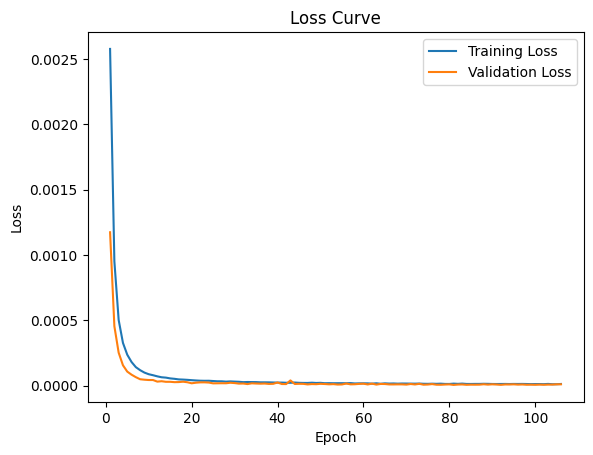

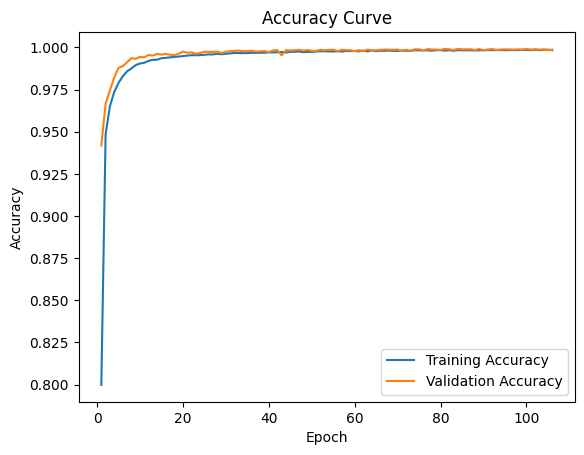

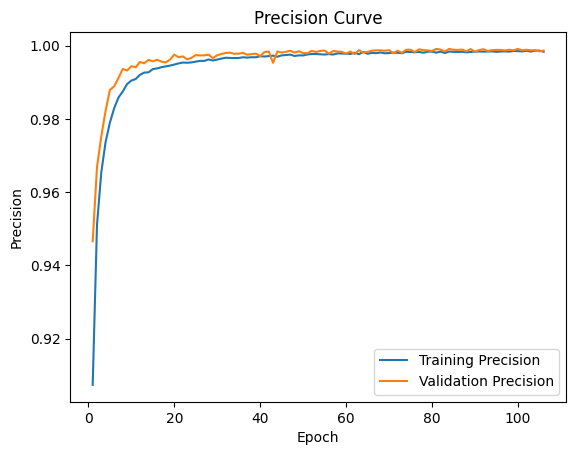

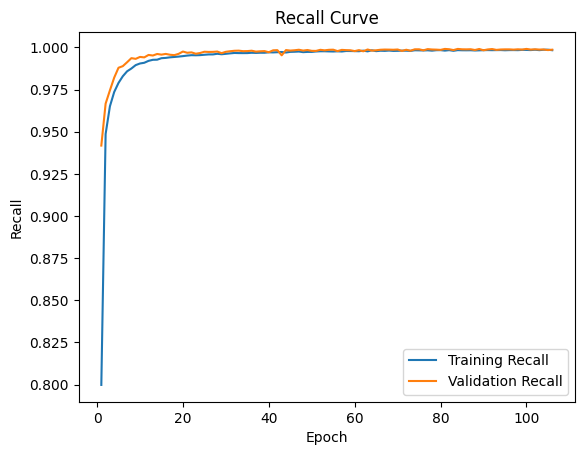

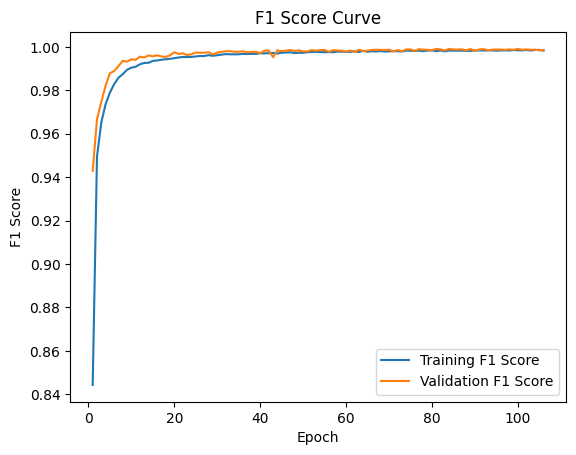

In [88]:
import matplotlib.pyplot as plt
num_epochs = len(train_losses)
# 손실 곡선 저장
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.savefig('loss_curve.png')

# 정확도 곡선 저장
plt.figure()
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.savefig('accuracy_curve.png')

# Precision 곡선 저장
plt.figure()
plt.plot(range(1, num_epochs + 1), train_precisions, label='Training Precision')
plt.plot(range(1, num_epochs + 1), val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision Curve')
plt.legend()
plt.savefig('precision_curve.png')

# Recall 곡선 저장
plt.figure()
plt.plot(range(1, num_epochs + 1), train_recalls, label='Training Recall')
plt.plot(range(1, num_epochs + 1), val_recalls, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall Curve')
plt.legend()
plt.savefig('recall_curve.png')

# F1 Score 곡선 저장
plt.figure()
plt.plot(range(1, num_epochs + 1), train_f1s, label='Training F1 Score')
plt.plot(range(1, num_epochs + 1), val_f1s, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Curve')
plt.legend()
plt.savefig('f1_score_curve.png')

# 테스트 정확도 평가
test_loss, test_acc, test_precision, test_recall, test_f1 = evaluate(test_loader)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}, Test Precision: {test_precision}, Test Recall: {test_recall}, Test F1 Score: {test_f1}')

# 최종 모델 저장
torch.save(model.state_dict(), 'gnn_model.pth')

# 최종 결과 출력
print(f'Final Training Loss: {train_losses[-1]}')
print(f'Final Validation Loss: {val_losses[-1]}')
print(f'Final Test Accuracy: {test_acc}')
print(f'Final Test Precision: {test_precision}')
print(f'Final Test Recall: {test_recall}')
print(f'Final Test F1 Score: {test_f1}')